## Testing individual sentences

In [19]:
from seq2seq.data.dictionary import Dictionary
import collections
import re
import torch
from seq2seq import models
import argparse
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt


torch.manual_seed(42)

SPACE_NORMALIZER = re.compile("\s+")

src_dict =Dictionary.load('europarl_prepared/dict.de')
tgt_dict = Dictionary.load('europarl_prepared/dict.en')


def load_model(model_path):
    state_dict = torch.load(model_path)
    source_lang, target_lang = 'de', 'en'
    # src_dict = Dictionary.load(os.path.join(data, 'dict.{:s}'.format(source_lang)))
    # print('Loaded a source dictionary ({:s}) with {:d} words'.format(source_lang, len(src_dict)))
    # tgt_dict = Dictionary.load(os.path.join(data, 'dict.{:s}'.format(target_lang)))
    # print('Loaded a target dictionary ({:s}) with {:d} words'.format(target_lang, len(tgt_dict)))
        # Build model and optimization criterion
    model = models.build_model(state_dict['args'], src_dict, tgt_dict)
    model.eval()
    model.load_state_dict(state_dict['model'])
    return model


In [20]:



def word_tokenize(line):
    line = SPACE_NORMALIZER.sub(" ", line)
    line = line.strip()
    return line.split()

unk_counter = collections.Counter()

def unk_consumer(word, idx):
    if idx == src_dict.unk_idx and word != src_dict.unk_word:
        unk_counter.update([word])

def merge(values, move_eos_to_beginning=False):
    max_length = max(v.size(0) for v in values)
    result = values[0].new(len(values), max_length).fill_(src_dict.pad_idx)
    for i, v in enumerate(values):
        if move_eos_to_beginning:
            assert v[-1] == src_dict.eos_idx
            result[i, 0] = src_dict.eos_idx
            result[i, 1:len(v)] = v[:-1]
        else:
            result[i, :len(v)].copy_(v)
    return result


def generate_tokens(lines):  
    tokens_list, len_list = [], []
    for line in lines:

        tokens = src_dict.binarize(line.strip(), word_tokenize, append_eos=True, consumer=unk_consumer)
    
        tokens = torch.tensor([tokens.numpy()]).to(torch.int64)
        tokens = merge([s for s in tokens])
        lengths = torch.LongTensor([s.numel() for s in tokens])
        lengths, sort_order = lengths.sort(descending=True)
        tokens.index_select(0, sort_order)
        tokens_list.append(tokens)
        len_list.append(lengths)
    return tokens_list, len_list


In [88]:


def generate_output(model, tokens, lengths, max_len = 25):
    all_hyps, attn_weights_all = {}, []
    for i, _ in enumerate(tokens):
        with torch.no_grad():
            encoder_out = model.encoder(tokens[i], lengths[i])
            go_slice = \
                torch.ones(tokens[i].shape[0], 1).fill_(tgt_dict.eos_idx).type_as(tokens[i])
            prev_words = go_slice
            next_words = None
        for _ in range(max_len):
            with torch.no_grad():
                # Compute the decoder output by repeatedly feeding it the decoded sentence prefix
                decoder_out, attn_weights = model.decoder(prev_words, encoder_out)
            # Suppress <UNK>s
            _, next_candidates = torch.topk(decoder_out, 2, dim=-1)
            best_candidates = next_candidates[:, :, 0]
            backoff_candidates = next_candidates[:, :, 1]
            next_words = torch.where(best_candidates == tgt_dict.unk_idx, backoff_candidates, best_candidates)
            prev_words = torch.cat([go_slice, next_words], dim=1)
        decoded_batch = next_words.numpy()
        output_sentences = [decoded_batch[row, :] for row in range(decoded_batch.shape[0])]
        # Remove padding
        temp = list()
        for sent in output_sentences:
            first_eos = np.where(sent == tgt_dict.eos_idx)[0]
            if len(first_eos) > 0:
                temp.append(sent[:first_eos[0]])
            else:
                temp.append([])
        output_sentences = temp

        # Convert arrays of indices into strings of words
        output_sentences = [tgt_dict.string(sent) for sent in output_sentences]
        for ii, sent in enumerate(output_sentences):
            all_hyps[i] = sent
        attn_weights_all.append(attn_weights)

    return all_hyps, attn_weights_all


def plot_sents(input, output, attn_weights):
    for i in range(len(output.keys())):
        attn_map = attn_weights[i].squeeze(dim=0).transpose(1, 0).detach().cpu().numpy()
        src_str = input[i].split(' ') + ['<EOS>']
        tgt_str = output[i].split(' ') + ['<EOS>']
        attn_map = attn_map[:, :len(tgt_str)]
        attn_df = pd.DataFrame(attn_map,
                                index=src_str,
                                columns=tgt_str)

        sns.heatmap(attn_df, cmap='Blues', linewidths=0.25, vmin=0.0, vmax=1.0, xticklabels=True, yticklabels=True,
                    fmt='.3f')
        plt.yticks(rotation=0)
        plt.show()
        plt.clf()

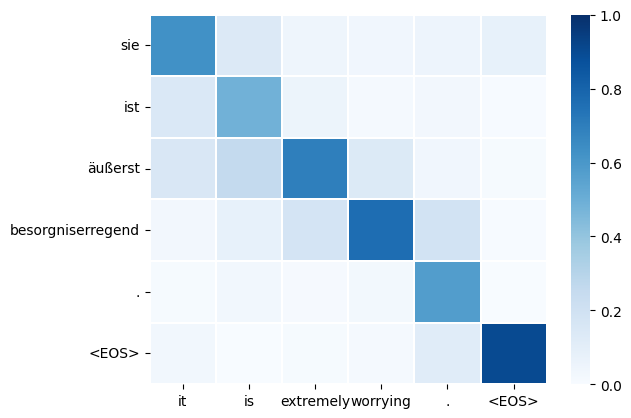

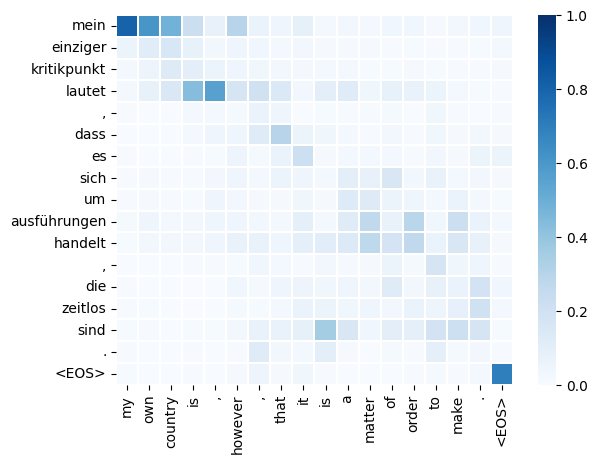

<Figure size 640x480 with 0 Axes>

In [89]:
lines = ['sie ist äußerst besorgniserregend .', 'mein einziger kritikpunkt lautet , dass es sich um ausführungen handelt , die zeitlos sind .']

model = load_model('../lexical model checkpoints/checkpoint_lexical.pt')
tokens, lengths = generate_tokens(lines)
all_hyps, attn_weights_all = generate_output(model, tokens, lengths)
plot_sents(lines, all_hyps, attn_weights_all)


(4, 3)
(6, 25)
(6, 6)


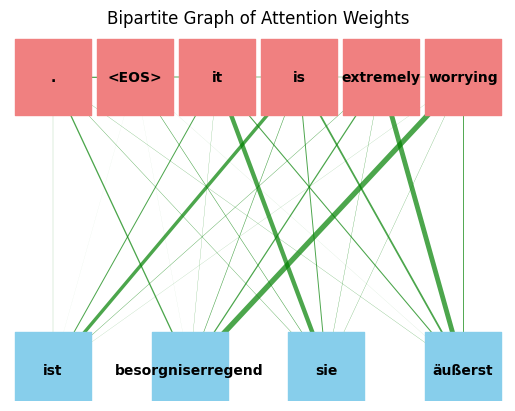

In [87]:
import networkx as nx
from collections import OrderedDict

import matplotlib.pyplot as plt

def visualize_attention_bipartite(source_words, target_words, attention_weights):
    G = nx.Graph()

    # Add nodes for source and target words
    G.add_nodes_from(source_words, bipartite=0, color='skyblue')
    G.add_nodes_from(target_words, bipartite=1, color='lightcoral')

    # Add edges with attention weights
    for i, source_word in enumerate(source_words):
        for j, target_word in enumerate(target_words):
            weight = attention_weights[j][i]
            G.add_edge(source_word, target_word, weight=weight)

    # Separate nodes by their bipartite attribute for visualization
    source_nodes = {n for n, d in G.nodes(data=True) if d['bipartite'] == 0}
    target_nodes = {n for n, d in G.nodes(data=True) if d['bipartite'] == 1}

    # Draw graph
    pos = nx.bipartite_layout(G, source_nodes, align='horizontal')
    edge_widths = [5 * G[u][v]['weight'] for u, v in G.edges()]

    node_colors = [d['color'] for n, d in G.nodes(data=True)]
   
    nx.draw_networkx_nodes(G, pos, nodelist=source_nodes, node_color=node_colors[:len(source_nodes)], node_size=3000, node_shape='s')
    nx.draw_networkx_nodes(G, pos, nodelist=target_words, node_color=node_colors[len(source_nodes):], node_size=3000, node_shape='s')
    
    nx.draw_networkx_edges(G, pos, width=edge_widths, edge_color='green', alpha=0.7)

    # Draw node labels
    for node, (x, y) in pos.items():
        plt.text(x, y, node, ha='center', va='center', color='black', fontsize=10, fontweight='bold')

    plt.title('Bipartite Graph of Attention Weights')
    plt.axis('off')
    plt.show()

    

# Example data
source_words = ['Je', 'suis', 'étudiant']
target_words = ['I', 'am', 'a', 'student']
attention_weights = np.array([[0.2, 0.3, 0.5],
                              [0.1, 0.6, 0.3],
                              [0.4, 0.4, 0.2],
                              [0.3, 0.2, 0.5]])
print(attention_weights.shape)
attn_map = attn_weights_all[0].squeeze(dim=0).transpose(1, 0).detach().cpu().numpy()
print(attn_map.shape)

src_str = lines[i].split(' ') + ['<EOS>']
tgt_str = all_hyps[i].split(' ') + ['<EOS>']
attn_map = attn_map[:, :len(tgt_str)].transpose()
print(attn_map.shape)
visualize_attention_bipartite(src_str, tgt_str, attn_map)
